In [1]:
#set xla parameters for using gpu
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.99
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from scipy.optimize import minimize

import jax
#use 64 bit floats
from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit, vmap
import jax.scipy as jsp
from functools import partial
import matplotlib
from tqdm.auto import tqdm
import optimistix as optx

import oifits_implaneia as oifits

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: XLA_PYTHON_CLIENT_ALLOCATOR=platform
env: XLA_PYTHON_CLIENT_MEM_FRACTION=.99


/tmp/ipykernel_64362/2669484810.py:16: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config; config.update("jax_enable_x64", True)


In [2]:
plt.figure()
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 14})

<Figure size 640x480 with 0 Axes>

In [3]:
def cp_indices(vis_sta_index, cp_sta_index):
    """Extracts indices for calculating closure phase from visibility and closure phase station indices"""
    i_cps1 = np.zeros(len(cp_sta_index),np.int32)
    i_cps2 = np.zeros(len(cp_sta_index),np.int32)
    i_cps3 = np.zeros(len(cp_sta_index),np.int32)

    for i in range(len(cp_sta_index)):
        i_cps1[i] = np.argwhere((cp_sta_index[i][0]==vis_sta_index[:,0])&(cp_sta_index[i][1]==vis_sta_index[:,1]))[0,0]
        i_cps2[i] = np.argwhere((cp_sta_index[i][1]==vis_sta_index[:,0])&(cp_sta_index[i][2]==vis_sta_index[:,1]))[0,0]
        i_cps3[i] = np.argwhere((cp_sta_index[i][0]==vis_sta_index[:,0])&(cp_sta_index[i][2]==vis_sta_index[:,1]))[0,0]
    return i_cps1,i_cps2,i_cps3 

In [4]:
def load_oifits(filename,directory):
    wav = []
    wav_band = []
    vis2 = []
    vis2_err = []
    u = []
    v = []
    cp = []
    cp_err = []
    u1_cp = []
    v1_cp = []
    u2_cp = []
    v2_cp = []
    i_cps1 = []
    i_cps2 = []
    i_cps3 = []
    v2_cov_inv = []
    cp_cov_inv = []
    ind1 = 0
    wav_b = []
    #Load the oifits 
    dat = os.path.join(directory, filename)
    obj = oifits.load(dat)
    #extract important quantities and append to lists
    wav.append(obj['OI_WAVELENGTH']['EFF_WAVE'])
    wav_b.append(obj['OI_WAVELENGTH']['EFF_BAND'])
    vis2.append(obj['OI_VIS2']['VIS2DATA'])
    vis2_err.append(obj['OI_VIS2']['VIS2ERR'])
    u.append(obj['OI_VIS2']['UCOORD'])
    v.append(obj['OI_VIS2']['VCOORD'])
    vis_sta_index = obj['OI_VIS2']['STA_INDEX']
    cp.append(obj['OI_T3']['T3PHI'])
    cp_err.append(obj['OI_T3']['T3PHIERR'])
    wav_band.append(obj['OI_WAVELENGTH']['EFF_BAND'])
    cp_sta_index = obj['OI_T3']['STA_INDEX']
    i_cps1t,i_cps2t,i_cps3t = cp_indices(vis_sta_index, cp_sta_index)

    i_cps1.append(i_cps1t+ind1*21)
    i_cps2.append(i_cps2t+ind1*21)
    i_cps3.append(i_cps3t+ind1*21)
    ind1 += 1
    wav = jnp.array(wav)
    vis2 = jnp.array(vis2)
    vis2_err = jnp.array(vis2_err)
    u = jnp.array(u)
    v = jnp.array(v)
    cp = jnp.array(cp)
    cp_err = jnp.array(cp_err)
    i_cps1 = jnp.array(i_cps1)
    i_cps2 = jnp.array(i_cps2)
    i_cps3 = jnp.array(i_cps3)

    a21 = jnp.argwhere(wav)[:,0]
    wav21 = wav[a21][0,:][0]
    vis221 =(jnp.array(vis2)[a21,:])
    vis2_err21 = jnp.hstack(jnp.array(vis2_err)[a21,:])
    u21 = jnp.hstack(jnp.array(u)[a21,:])
    v21 = jnp.hstack(jnp.array(v)[a21,:])
    cp21 = (jnp.array(cp)[a21,:])
    cp_err21 = jnp.hstack(jnp.array(cp_err)[a21,:])
    i_cps121 = jnp.hstack(jnp.array(i_cps1)[a21,:])
    i_cps221 = jnp.hstack(jnp.array(i_cps2)[a21,:])
    i_cps321 = jnp.hstack(jnp.array(i_cps3)[a21,:])
    #convert u,v to wavelengths
    u21 = jnp.hstack(u21/wav21)
    v21 = jnp.hstack(v21/wav21)
    dwav21 = wav_band[a21[0]][0]
    
    return cp21,cp_err21,vis221,vis2_err21,u21,v21,i_cps121,i_cps221,i_cps321

In [5]:
fn = "NuHor_F480M.oifits"
dr = "../Saveoifits"
cp,cp_err,vis2,vis2_err,u,v,i_cps1,i_cps2,i_cps3=load_oifits(fn,dr)

2024-02-07 10:28:29.156860: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.103). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [6]:
rad2mas = 180./np.pi*3600.*1000. # convert rad to mas
mas2rad = np.pi/180./3600./1000. # convert mas to rad

In [7]:
def get_grid(sep_range,
             step_size,
             verbose=False):
    """
    Parameters
    ----------
    sep_range: tuple of float
        Min. and max. angular separation of grid (mas).
    step_size: float
        Step size of grid (mas).
    verbose: bool
        True if feedback shall be printed.
    
    Returns
    -------
    grid_ra_dec: tuple of array
        grid_ra_dec[0]: array
            Right ascension offset of grid cells (mas).
        grid_ra_dec[1]: array
            Declination offset of grid cells (mas).
    grid_sep_pa: tuple of array
        grid_sep_pa[0]: array
            Angular separation of grid cells (mas).
        grid_sep_pa[1]: array
            Position angle of grid cells (deg).
    """
    
    if (verbose == True):
        print('Computing grid')
    
    nc = int(np.ceil(sep_range[1]/step_size))
    temp = np.linspace(-nc*step_size, nc*step_size, 2*nc+1)
    grid_ra_dec = np.meshgrid(temp, temp)
    grid_ra_dec[0] = np.fliplr(grid_ra_dec[0])
    sep = np.sqrt(grid_ra_dec[0]**2+grid_ra_dec[1]**2)
    pa = np.rad2deg(np.arctan2(grid_ra_dec[0], grid_ra_dec[1]))
    grid_sep_pa = np.array([sep, pa])
    
    mask = (sep < sep_range[0]-1e-6) | (sep_range[1]+1e-6 < sep)
    grid_ra_dec[0][mask] = np.nan
    grid_ra_dec[1][mask] = np.nan
    grid_sep_pa[0][mask] = np.nan
    grid_sep_pa[1][mask] = np.nan
    
    if (verbose):
        print('   Min. sep. = %.1f mas' % np.nanmin(grid_sep_pa[0]))
        print('   Max. sep. = %.1f mas' % np.nanmax(grid_sep_pa[0]))
        print('   %.0f non-empty grid cells' % np.sum(np.logical_not(np.isnan(grid_sep_pa[0]))))
    
    return grid_ra_dec, grid_sep_pa

In [8]:
def azimuthalAverage(image, center=None, stddev=False, returnradii=False, return_nr=False, 
        binsize=0.5, weights=None, steps=False, interpnan=False, left=None, right=None, return_max=False):
    """
    Calculate the azimuthally averaged radial profile.
    NB: This was found online and should be properly credited! Modified by MJI

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fractional pixels).
    stddev - if specified, return the azimuthal standard deviation instead of the average
    returnradii - if specified, return (radii_array,radial_profile)
    return_nr   - if specified, return number of pixels per radius *and* radius
    binsize - size of the averaging bin.  Can lead to strange results if
        non-binsize factors are used to specify the center and the binsize is
        too large
    weights - can do a weighted average instead of a simple average if this keyword parameter
        is set.  weights.shape must = image.shape.  weighted stddev is undefined, so don't
        set weights and stddev.
    steps - if specified, will return a double-length bin array and radial
        profile so you can plot a step-form radial profile (which more accurately
        represents what's going on)
    interpnan - Interpolate over NAN values, i.e. bins where there is no data?
        left,right - passed to interpnan; they set the extrapolated values
    return_max - (MJI) Return the maximum index.

    If a bin contains NO DATA, it will have a NAN value because of the
    divide-by-sum-of-weights component.  I think this is a useful way to denote
    lack of data, but users let me know if an alternative is prefered...
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if center is None:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    if weights is None:
        weights = np.ones(image.shape)
    elif stddev:
        raise ValueError("Weighted standard deviation is not defined.")

    # the 'bins' as initially defined are lower/upper bounds for each bin
    # so that values will be in [lower,upper)  
    nbins = int(np.round(r.max() / binsize)+1)
    maxbin = nbins * binsize
    bins = np.linspace(0,maxbin,nbins+1)
    # but we're probably more interested in the bin centers than their left or right sides...
    bin_centers = (bins[1:]+bins[:-1])/2.0

    # Find out which radial bin each point in the map belongs to
    whichbin = np.digitize(r.flat,bins)

    # how many per bin (i.e., histogram)?
    # there are never any in bin 0, because the lowest index returned by digitize is 1
    nr = np.bincount(whichbin)[1:]

    # recall that bins are from 1 to nbins (which is expressed in array terms by arange(nbins)+1 or xrange(1,nbins+1) )
    # radial_prof.shape = bin_centers.shape

    if stddev:
        radial_prof = np.array([image.flat[whichbin==b].std() for b in range(1,nbins+1)])
    elif return_max:
        radial_prof = np.array([np.append((image*weights).flat[whichbin==b],-np.inf).max() for b in range(1,nbins+1)])
    else:
        radial_prof = np.array([(image*weights).flat[whichbin==b].sum() / weights.flat[whichbin==b].sum() for b in range(1,nbins+1)])

    #import pdb; pdb.set_trace()

    if interpnan:
        radial_prof = np.interp(bin_centers,bin_centers[radial_prof==radial_prof],radial_prof[radial_prof==radial_prof],left=left,right=right)

    if steps:
        xarr = np.array(zip(bins[:-1],bins[1:])).ravel() 
        yarr = np.array(zip(radial_prof,radial_prof)).ravel() 
        return xarr,yarr
    elif returnradii: 
        return bin_centers,radial_prof
    elif return_nr:
        return nr,bin_centers,radial_prof
    else:
        return radial_prof

In [9]:
def vis_binary(u, v, ddec,dra,planet,star=1.):
    #adapted from pymask
    ''' Calculate the complex visibilities observed by an array on a binary star
    ----------------------------------------------------------------
    - ddec = ddec (mas)
    - dra = dra (mas)
    - planet = planet brightness
    - star = star brightness


    - u,v: baseline coordinates (wavelengths)
    ---------------------------------------------------------------- '''

    #normalize visibilities so total power is 1
    p3 = star/(star+planet)
    p2 = planet/(star+planet)

    # relative locations
    ddec = ddec*np.pi/(180.*3600.*1000.)
    dra =  dra*np.pi/(180.*3600.*1000.)
    phi_r = jnp.cos(-2*np.pi*(u*dra + v*ddec))
    phi_i = jnp.sin(-2*np.pi*(u*dra + v*ddec))

    cvis = p3+p2*phi_r+p2*phi_i*1.0j

    return cvis

In [10]:
@jit
def closure_phases(vis,index_cps1,index_cps2,index_cps3):
    #calculate closure phases [degrees] from complex visibilities and cp indices
    real = jnp.real(vis)
    imag = jnp.imag(vis)
    visphiall = jnp.arctan2(imag,real)
    visphiall = jnp.mod(visphiall + 10980., 360.)-180.
    visphi = jnp.reshape(visphiall,(len(vis),1))
    cp = visphi[jnp.array(index_cps1)] + visphi[jnp.array(index_cps2)] - visphi[jnp.array(index_cps3)]
    out = jnp.reshape(cp*180/np.pi,len(index_cps1))
    return out

In [11]:
def log_like_binary(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast):
    #adapted from pymask
    ''' Calculate the unnormalized log-likelihood of an unresolved binary star model
    ----------------------------------------------------------------
    - ddec = companion dec offset (mas)
    - dra = companion ra offset (mas)
    - cp = closure phases (deg)
    - d_cp = closure phase uncertainty (deg)
    - vis2 = squared visibilties 
    - d_vis2 = squared visibilty uncertainty 
    - planet_contrast = planet
    - u,v: baseline coordinates (wavelengths)
    ---------------------------------------------------------------- '''

    cvis_model = vis_binary(u, v, ddec,dra,planet_contrast)
    
    #calculate model observables
    cp_obs = closure_phases(cvis_model,i_cps1,i_cps2,i_cps3)
    vis2_obs = jnp.abs(cvis_model)**2
    
    ll_cp = jnp.sum((cp_obs-cp)**2/d_cp**2)
    ll_vis2 = jnp.sum((vis2_obs-vis2)**2/d_vis2**2)
    
    return -0.5*(ll_cp+ll_vis2)


In [12]:
def log_like_star(cp, d_cp, vis2, d_vis2):
    ''' Calculate the unnormalized log-likelihood of an unresolved star model
    ----------------------------------------------------------------
    - cp = closure phases (deg)
    - d_cp = closure phase uncertainty (deg)
    - vis2 = squared visibilties 
    - d_vis2 = squared visibilty uncertainty 
    ---------------------------------------------------------------- '''

    #calculate model observables
    cp_obs = 0.
    vis2_obs = 1.
    
    ll_cp = jnp.sum((cp_obs-cp)**2/d_cp**2)
    ll_vis2 = jnp.sum((vis2_obs-vis2)**2/d_vis2**2)
    
    return -0.5*(ll_cp+ll_vis2)

In [13]:
#define a function to calculate a log likelihood grid 
inner_fun = partial(vmap(log_like_binary, in_axes=(None,None,None,None,None,None,None,None,None,0,0,None)))
outer_fun = partial(vmap(inner_fun, in_axes=(None,None,None,None,None,None,None,None,None,None,None,0)))
log_like_binary_map = jit(outer_fun)

In [14]:
#calculate ra/dec grid
dx = 5
ra_dec_grid,_ = get_grid(sep_range=[10.,600.], step_size=dx, verbose=False)
#size of grid
nx = ra_dec_grid[0].shape[0]
nb = u.shape
dra  = ra_dec_grid[0].flatten()
ddec = ra_dec_grid[1].flatten()
#number of contrasts to calculate
nconts = 100
planet_contrast = 10**np.linspace(-6,-1,nconts)

#simulate cvis data - overwrite loaded nu hor data for now
ddec_inp = 150
dra_inp = 150
simulated_data = True
p_inj_cont = 5e-4
if simulated_data:
    cvis = vis_binary(u, v, ddec=ddec_inp,dra=dra_inp,planet=p_inj_cont)
    cp = closure_phases(cvis,i_cps1,i_cps2,i_cps3)
    #add uncorrelated gaussian noise
    cp += np.random.normal(0,cp_err)
    vis2 = jnp.abs(cvis)**2
    vis2 += np.random.normal(0,vis2_err)
    d_cp = cp_err.copy()
    d_vis2 = vis2_err.copy()
else:
    d_cp = jnp.sqrt(cp_err.copy()**2+np.std(cp)**2)
    d_vis2 = jnp.sqrt(vis2_err.copy()**2+np.std(vis2)**2)

# Create a log likelihood map over a grid of ra, dec, contrast, with the contrast that maximizes the likelihood.

In [15]:
ll_map = log_like_binary_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast)
#reshape likelihood map into number of contrasts , image size
ll_map_rs = ll_map.reshape(nconts,nx,nx) 
#save indices from grid fit for initialization of contrast fit
inds_cont = np.argmax(ll_map_rs,axis=0)
max_ll_map = jnp.nanmax(ll_map_rs,axis=0)
mask = 0.*max_ll_map #define an additive nan mask

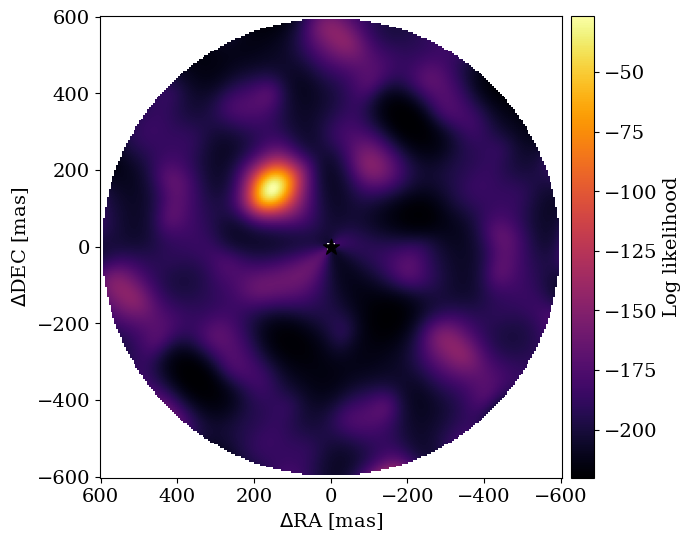

In [16]:
plt.figure(figsize=(12,6))
plt.imshow(max_ll_map,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1)
plt.colorbar(shrink=1,label='Log likelihood', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
#plt.scatter(dra_inp,ddec_inp, 
#            s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis()
plt.show()

In [17]:
def log_like_wrap(planet_contrast,u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra):
    
    return -log_like_binary(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast)

def optimize_log_like(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast):
    
    sol = optx.compat.minimize(log_like_wrap,method='BFGS',
                                x0=jnp.array([planet_contrast]), args=(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra),options={"maxiter":100})
    res = sol.x


    return res

In [18]:

#define a function to find the contrast that maximizes the log likelihood
vmap_fun = partial(vmap(optimize_log_like, in_axes=(None,None,None,None,None,None,None,None,None,0,0,0)))
optimize_log_like_map = jit(vmap_fun)

# Use gradient based optimization to find the local minima from the grid search.

In [19]:
contrasts = optimize_log_like_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,
                                  planet_contrast[inds_cont].flatten()+ mask.flatten())
contrasts_rs = contrasts.reshape(nx,nx) + mask

# this implementation does not make sense because the contrast at each pixel pepends on the contrast at all other pixels so is not a true upper limit. 
# We would have to do image reconstruction for this - need a model comparison approach

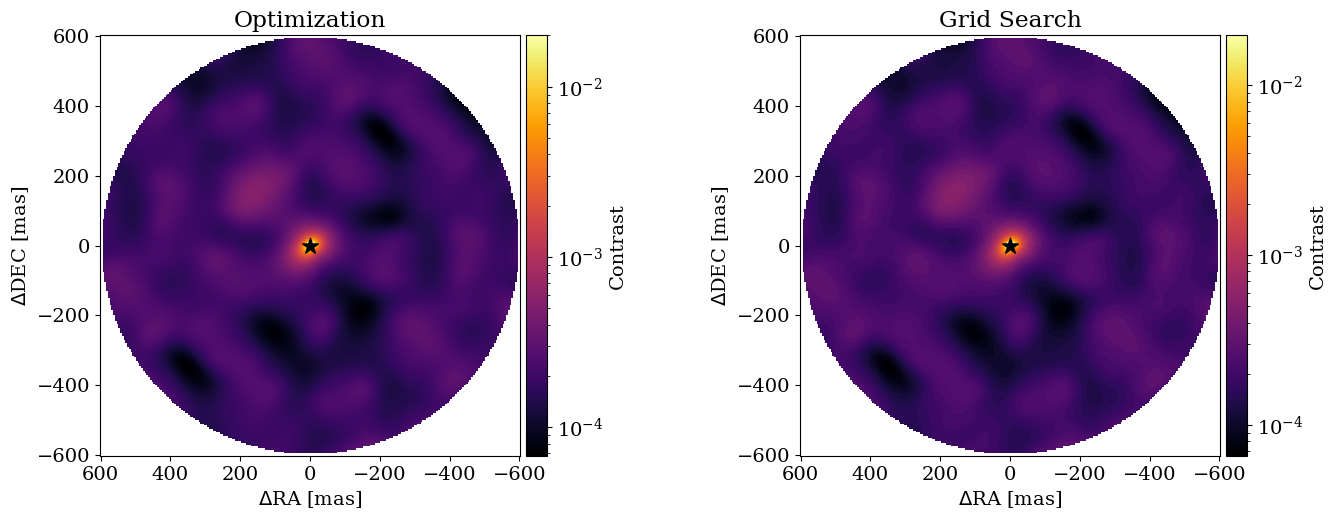

In [20]:
plt.figure(figsize=(14,5))
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
plt.imshow(contrasts_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('Optimization')
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(planet_contrast[inds_cont]+mask,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('Grid Search')
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.)
plt.show()

In [21]:
#calc sigma with laplace approximation
def sigma(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast):
    hess = jax.hessian(log_like_binary, argnums=[11])(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3,ddec,dra,planet_contrast)
    cov = -jnp.linalg.inv(jnp.array(hess))

    return jnp.sqrt(cov)

In [22]:
#define a function to find the contrast that maximizes the log likelihood
vmap_fun = partial(vmap(sigma, in_axes=(None,None,None,None,None,None,None,None,None,0,0,0)))
sigma_map = jit(vmap_fun)

# Use the Laplace approximation to calculate the variances on the best fit contrasts in each grid cell.

In [23]:
sigmas = sigma_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,contrasts_rs.flatten())
sigmas_rs = sigmas.reshape(nx,nx) + mask

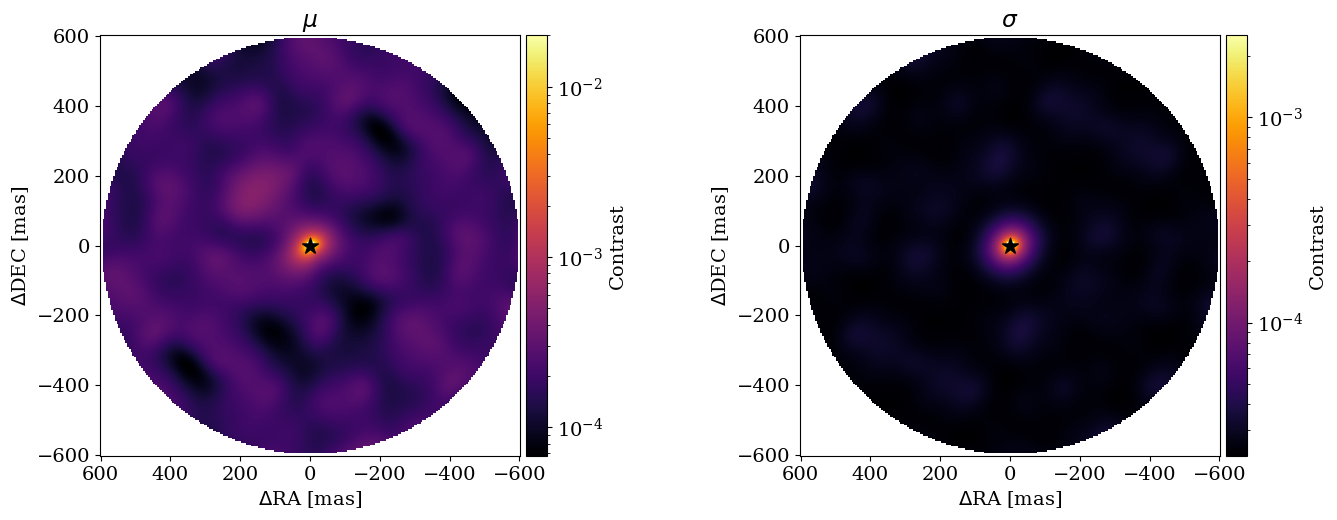

In [24]:
plt.figure(figsize=(14,5))
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
plt.imshow(contrasts_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('$\\mu$')
#plt.scatter(dra_inp,ddec_inp, 
#            s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(sigmas_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('$\\sigma$')
#plt.scatter(dra_inp,ddec_inp, 
#            s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.)
plt.show()

# Make a naive SNR map

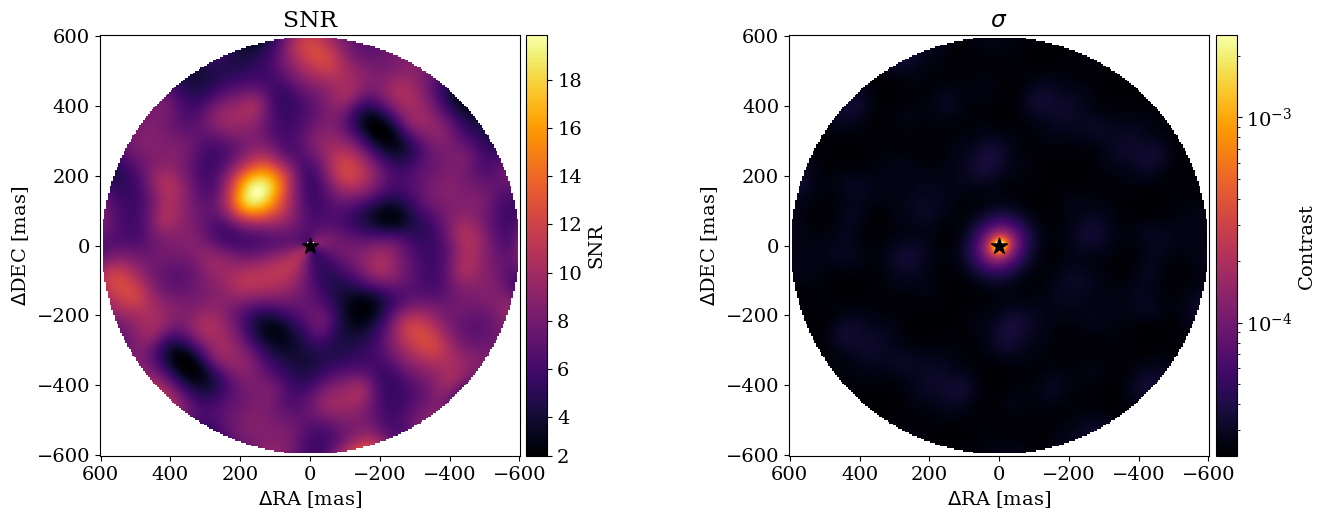

In [25]:
plt.figure(figsize=(14,5))
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 14})
plt.subplot(1,2,1)
plt.imshow(contrasts_rs/sigmas_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None, norm=matplotlib.colors.PowerNorm(1))
plt.colorbar(shrink=1,label='SNR', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('SNR')
#plt.scatter(dra_inp,ddec_inp, 
#            s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(sigmas_rs,cmap='inferno',
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = None,alpha=1, norm=matplotlib.colors.LogNorm())
plt.colorbar(shrink=1,label='Contrast', pad=0.01)
plt.scatter(0,0,s=140,c='black',marker='*')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.title('$\\sigma$')
#plt.scatter(dra_inp,ddec_inp, 
#            s=500,linestyle='--', facecolors='none', edgecolors='white',linewidths=2,alpha=1)
plt.gca().invert_yaxis()
plt.tight_layout(pad=0.)
plt.show()

In [26]:
@partial(vmap, in_axes=(0,0,None))
@partial(vmap, in_axes=(None,None,0))
def calc_upperlimit(mean,sigma,percentile):

    #eqn 8 from Ruffio+2018
    limit = jsp.stats.norm.ppf((percentile+(1-percentile)*jsp.stats.norm.cdf(0,loc=mean,scale=sigma)),loc=mean,scale=sigma)

    return limit

In [27]:
perc = jnp.array([jsp.stats.norm.cdf(2.)])
limits = calc_upperlimit(contrasts_rs.flatten(),sigmas_rs.flatten(),perc)
limits_rs = limits.reshape(nx,nx,perc.shape[0])
rad_wdith, avg_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:,0]), returnradii=True, binsize=2, stddev=False)
_, std_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:,0]), returnradii=True, binsize=2, stddev=True)

/tmp/ipykernel_64362/34803326.py:68: RuntimeWarning: invalid value encountered in scalar divide
  radial_prof = np.array([(image*weights).flat[whichbin==b].sum() / weights.flat[whichbin==b].sum() for b in range(1,nbins+1)])
/home/dori/anaconda3/envs/ami/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dori/anaconda3/envs/ami/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dori/anaconda3/envs/ami/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Calculate upper limits.

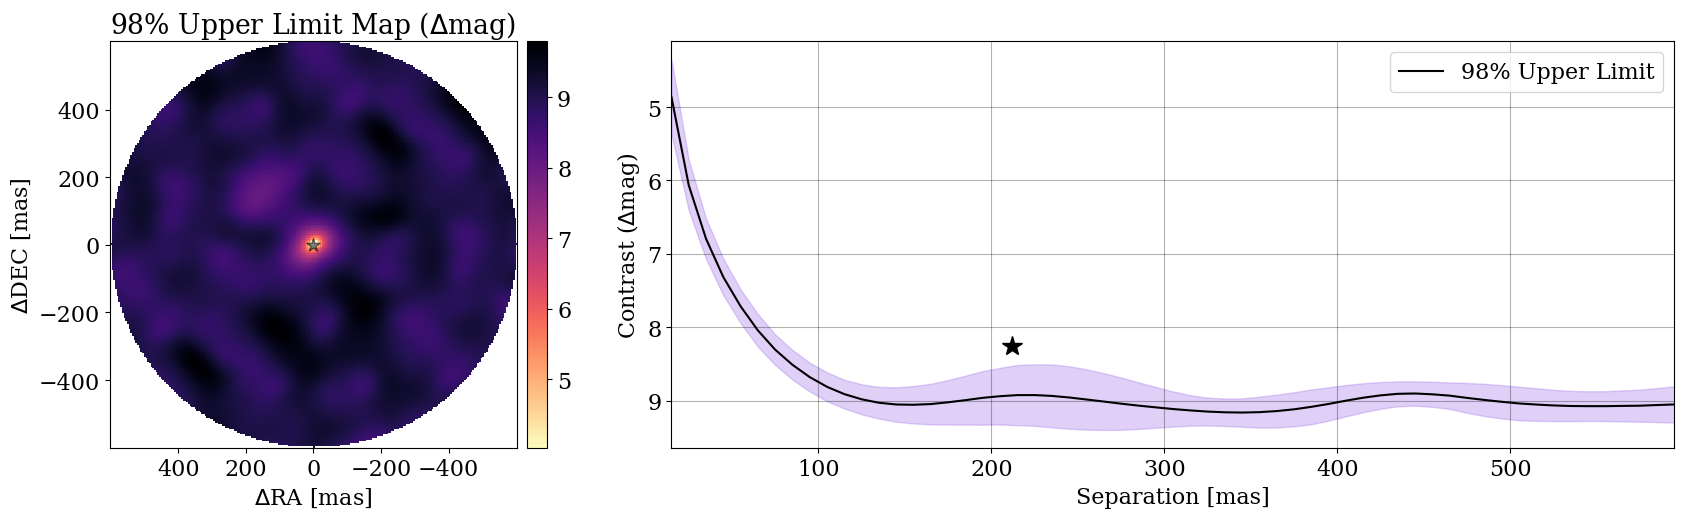

In [28]:
plt.figure(figsize=(20,5))
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 16})
plt.subplot(1,2,1)
plt.imshow(-2.5*jnp.log10(limits_rs[:,:,-1]),cmap=matplotlib.colormaps['magma_r'],
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = 'None',alpha=1)
plt.colorbar(shrink=1, pad=0.01)
plt.scatter(0,0,marker='*',s=100,c='black',alpha=0.5)
plt.gca().invert_yaxis()
plt.title('98% Upper Limit Map ($\\Delta$mag)')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.xticks([400,200,0,-200,-400])
plt.yticks([-400,-200,0,200,400])
plt.subplot(1,2,2)
plt.plot(rad_wdith*dx,avg_wdith,'-k',label="98% Upper Limit")
plt.fill_between(rad_wdith*dx,avg_wdith - std_wdith,avg_wdith + std_wdith,color=(0.6,0.4,0.9),alpha=0.3)
plt.ylabel('Contrast ($\\Delta$mag)')
plt.xlabel('Separation [mas]')
plt.gca().invert_yaxis()
plt.xlim(np.nanmin(rad_wdith*dx+avg_wdith*0.),np.nanmax(rad_wdith*dx+avg_wdith*0.))
plt.grid(color='black',alpha=0.3)
plt.legend(loc='best')
plt.tight_layout(pad=0.)
plt.plot(jnp.sqrt(ddec_inp**2+dra_inp**2),-2.5*jnp.log10(p_inj_cont),marker='*',c='k',markersize=15)
plt.show()

In [30]:
#size = 10_000_000
#xs = np.logspace(-15,0,size)
#ppf_arr = np.zeros(size)
#for i in tqdm(range(size)):
#    ppf_arr[i] = stats.chi2.ppf(1-xs[i],1)
#np.save("chi2_ppf", ppf_arr)
#np.save("chi2_ppf_xs", xs)

In [31]:
ppf_arr = np.load("chi2_ppf.npy")
xs = np.load("chi2_ppf_xs.npy")

In [32]:
def chi2_binary(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast):
    #adapted from pymask
    ''' Calculate the unnormalized log-likelihood of an unresolved binary star model
    ----------------------------------------------------------------
    - ddec = companion dec offset (mas)
    - dra = companion ra offset (mas)
    - cp = closure phases (deg)
    - d_cp = closure phase uncertainty (deg)
    - vis2 = squared visibilties 
    - d_vis2 = squared visibilty uncertainty 
    - planet_contrast = planet
    - u,v: baseline coordinates (wavelengths)
    ---------------------------------------------------------------- '''

    cvis_model = vis_binary(u, v, ddec,dra,planet_contrast)
    
    #calculate model observables
    cp_obs = closure_phases(cvis_model,i_cps1,i_cps2,i_cps3)
    vis2_obs = jnp.abs(cvis_model)**2
    
    ll_cp = jnp.sum((cp_obs-cp)**2/d_cp**2)
    ll_vis2 = jnp.sum((vis2_obs-vis2)**2/d_vis2**2)
    
    return (ll_cp+ll_vis2)

In [34]:
def nsigma_wrap(planet_contrast,u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,xs,ppf_arr,ndof,sigma):

    #constraints
    planet_contrast = jnp.where(planet_contrast<1e-6,1e-6,planet_contrast)
    planet_contrast = jnp.where(planet_contrast>1.,1.,planet_contrast)

    chi2_s = chi2_binary(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, 0.,0.,0.)/ndof 
    chi2_b = chi2_binary(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast)/ndof

    q = jsp.stats.chi2.cdf(ndof*chi2_b/chi2_s, ndof)
    p = 1.-q

    nsigma = jnp.sqrt(jnp.interp(p,xs,ppf_arr))

    nsigma_overflow = jnp.sqrt(jnp.interp(1e-15,xs,ppf_arr))

    nsigmavar = jnp.where(p<1e-15,nsigma_overflow,nsigma)

    return (sigma-nsigmavar)**2

def optimize_nsigma(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,planet_contrast,xs,ppf_arr,ndof,sigma):
    
    sol = optx.compat.minimize(nsigma_wrap,method='BFGS',
                                x0=jnp.array([planet_contrast]), args=(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,xs,ppf_arr,ndof,sigma),options={"maxiter":100})
    
    res = sol.x

    return res

#define a function to find the contrast that maximizes the log likelihood
vmap_fun = partial(vmap(optimize_nsigma, in_axes=(None,None,None,None,None,None,None,None,None,0,0,0,None,None,None,None)))
optimize_nsigma_map = jit(vmap_fun)

In [35]:
#define a function to calculate a log likelihood grid 
inner_fun = partial(vmap(nsigma_wrap, in_axes=(None,None,None,None,None,None,None,None,None,None,0,0,None,None,None,None)))
outer_fun = partial(vmap(inner_fun, in_axes=(0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None)))
nsigma_wrap_map = jit(outer_fun)

In [36]:
ndof = len(cp.flatten())+len(vis2.flatten())
sigma = 5.
nsigma_map = nsigma_wrap_map(planet_contrast, u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,jnp.array(xs),jnp.array(ppf_arr),ndof,sigma)
#reshape likelihood map into number of contrasts , image size
nsigma_map_rs = nsigma_map.reshape(nconts,nx,nx) 
#save indices from grid fit for initialization of contrast fit
inds_cont_ns = np.argmin(nsigma_map_rs,axis=0)
min_nsigma_map = jnp.nanmin(nsigma_map_rs,axis=0)
mask = 0.*min_nsigma_map #define an additive nan mask

In [37]:
limits = optimize_nsigma_map(u, v, cp, d_cp, vis2, d_vis2,i_cps1,i_cps2,i_cps3, ddec,dra,
                                  (jnp.clip(planet_contrast[inds_cont_ns].flatten()+ mask.flatten(),a_min=0,a_max=None)+1e-9),jnp.array(xs),jnp.array(ppf_arr),ndof,sigma)
limits_rs = limits.reshape(nx,nx) + mask

In [38]:
limits_rs = jnp.where(limits_rs<1e-6,1e-6,limits_rs)
limits_rs = jnp.where(limits_rs>1.,1.,limits_rs)

In [39]:
rad_wdith, avg_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:]), returnradii=True, binsize=2, stddev=False)
_, std_wdith  = azimuthalAverage(-2.5*np.log10(limits_rs[:,:]), returnradii=True, binsize=2, stddev=True)

/tmp/ipykernel_64362/34803326.py:68: RuntimeWarning: invalid value encountered in scalar divide
  radial_prof = np.array([(image*weights).flat[whichbin==b].sum() / weights.flat[whichbin==b].sum() for b in range(1,nbins+1)])
/home/dori/anaconda3/envs/ami/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/dori/anaconda3/envs/ami/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/dori/anaconda3/envs/ami/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


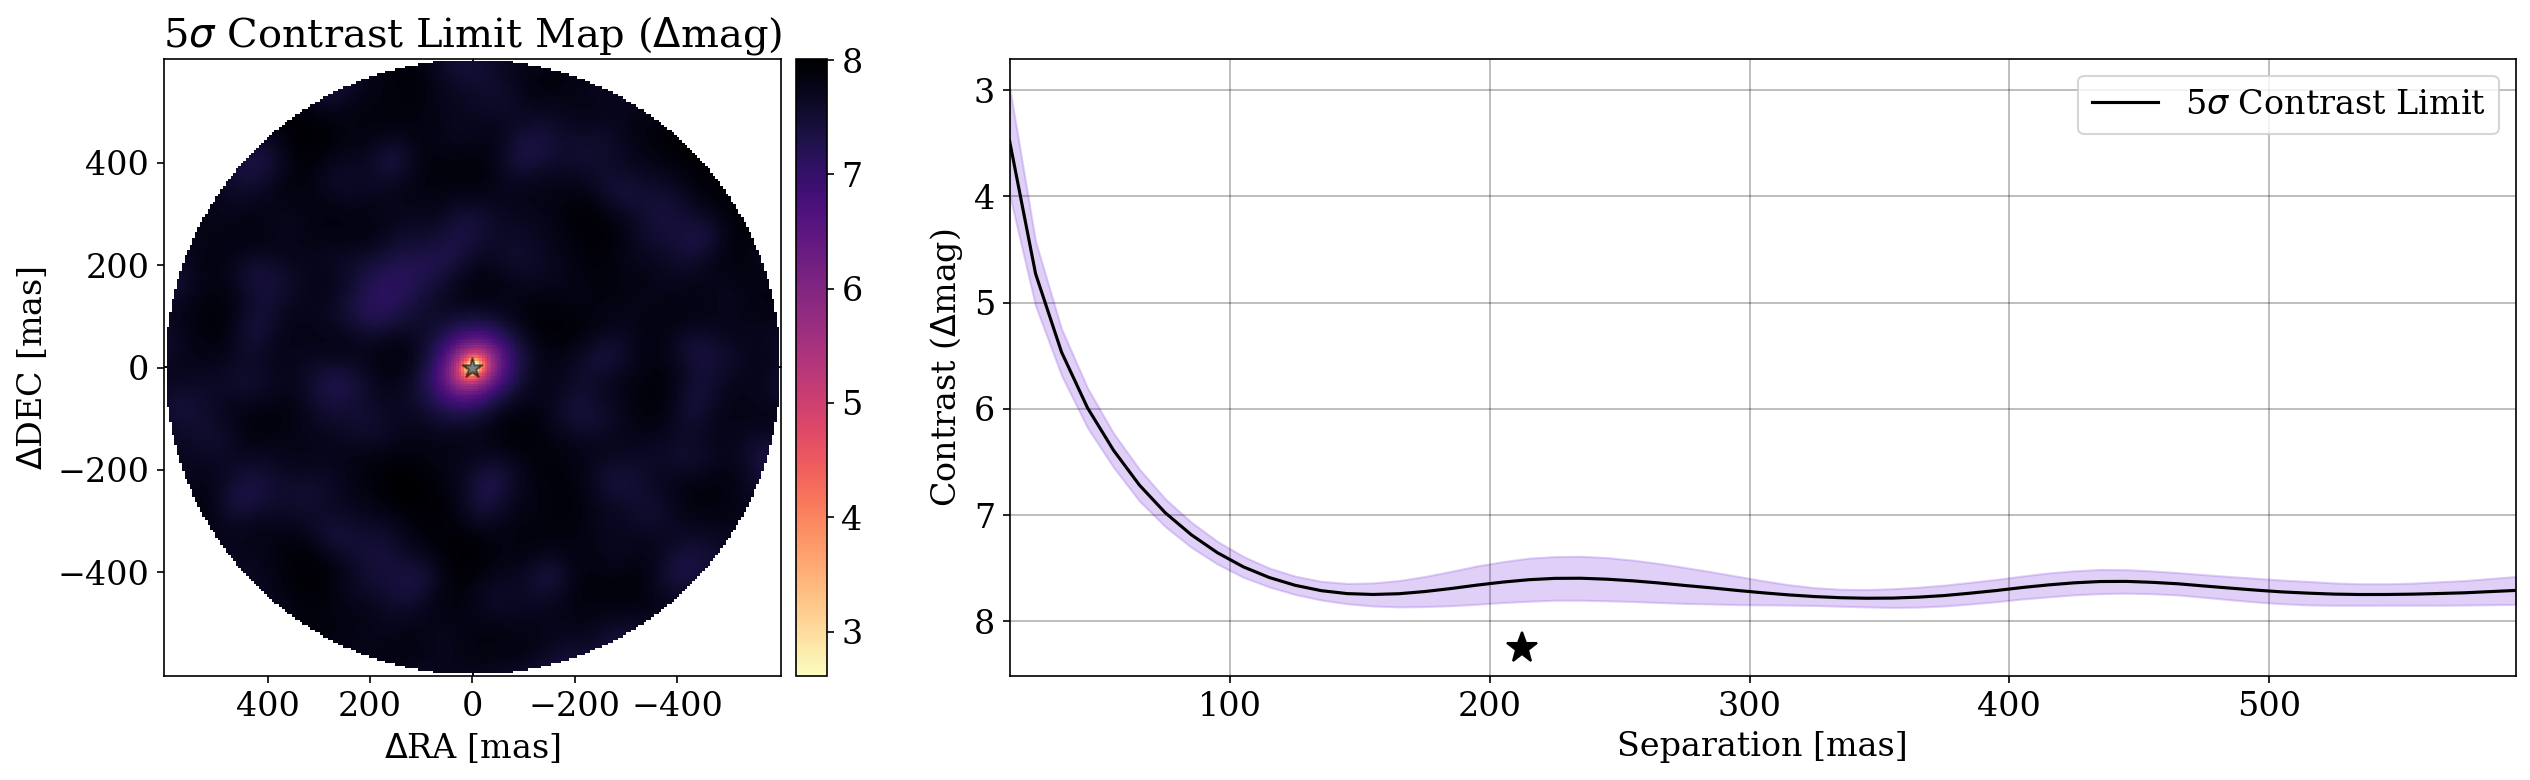

In [40]:
plt.figure(figsize=(20,5))
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 16})
plt.subplot(1,2,1)
plt.imshow(-2.5*jnp.log10(limits_rs[:,:]),cmap=matplotlib.colormaps['magma_r'],
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = 'None',alpha=1)
plt.colorbar(shrink=1, pad=0.01)
plt.scatter(0,0,marker='*',s=100,c='black',alpha=0.5)
plt.gca().invert_yaxis()
plt.title('5$\sigma$ Contrast Limit Map ($\\Delta$mag)')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.xticks([400,200,0,-200,-400])
plt.yticks([-400,-200,0,200,400])
plt.subplot(1,2,2)
plt.plot(rad_wdith*dx,avg_wdith,'-k',label="5$\sigma$ Contrast Limit")
plt.fill_between(rad_wdith*dx,avg_wdith - std_wdith,avg_wdith + std_wdith,color=(0.6,0.4,0.9),alpha=0.3)
plt.ylabel('Contrast ($\\Delta$mag)')
plt.xlabel('Separation [mas]')
plt.gca().invert_yaxis()
plt.xlim(np.nanmin(rad_wdith*dx+avg_wdith*0.),np.nanmax(rad_wdith*dx+avg_wdith*0.))
plt.grid(color='black',alpha=0.3)
plt.legend(loc='best')
plt.tight_layout(pad=0.)
plt.plot(jnp.sqrt(ddec_inp**2+dra_inp**2),-2.5*jnp.log10(p_inj_cont),marker='*',c='k',markersize=15)
plt.show()

# Do a comparison with the Absil method - functions are taken/adapted from Fouriever

In [45]:
ftol = 1e-3
sep_range = [10,500]
step_size=50
sigma=5
ndof = len(cp.flatten())+len(vis2.flatten())


def nsigma(chi2r_test,
           chi2r_true,
           ndof):
    """
    Parameters
    ----------
    chi2r_test: float
        Reduced chi-squared of test model.
    chi2r_true: float
        Reduced chi-squared of true model.
    ndof: int
        Number of degrees of freedom.
    
    Returns
    -------
    nsigma: float
        Detection significance.
    """
    
    q = stats.chi2.cdf(ndof*chi2r_test/chi2r_true, ndof)
    p = 1.-q
    nsigma = np.sqrt(stats.chi2.ppf(1.-p, 1.))
    if (p < 1e-15):
        nsigma = np.sqrt(stats.chi2.ppf(1.-1e-15, 1.))
    
    return nsigma

@jit
def vis_binary2(u, v, ddec,dra,p2,p3):
    #adapted from pymask
    ''' Calculate the complex visibilities observed by an array on a binary star
    ----------------------------------------------------------------
    - ddec = ddec (mas)
    - dra = dra (mas)
    - p2 = planet
    - p3 = star


    - u,v: baseline coordinates (wavelengths)
    ---------------------------------------------------------------- '''

    # relative locations
    ddec = (ddec)*np.pi/(180.*3600.*1000.)
    dra =  (dra)*np.pi/(180.*3600.*1000.)
    phi_r = jnp.cos(-2*np.pi*(u*dra + v*ddec))
    phi_i = jnp.sin(-2*np.pi*(u*dra + v*ddec))

    cvis = p3+p2*phi_r+p2*phi_i*1.0j

    return cvis

@jit
def chi2all(cp_modelr,v2_modelr,
            cp_obsr=cp.flatten(),
            vis2_obsr=vis2.flatten(),
            cp_errr=jnp.sqrt(cp_err**2).flatten(),
            vis2_errr=jnp.sqrt(vis2_err**2).flatten(),const=0.):
    
    # chi2 
    chi2_closurer = jnp.sum((cp_obsr - cp_modelr.flatten())**2 / cp_errr**2)

    chi2_v2r = jnp.sum((vis2_obsr - v2_modelr.flatten())**2 / (vis2_errr**2))

    return ( chi2_closurer+chi2_v2r) + const

#@jit
def chi2_suball(cont,vis_in,imsum,ddec,dra,u21=u,v21=v,
             i_cps121=i_cps1,
             i_cps221=i_cps2,i_cps321=i_cps3):
    cont = 10**cont
    cvis_t211 = vis_binary2(u21, v21, ddec = ddec,dra=dra,
                      p2=cont/(1.+cont+imsum),p3=1./(1.+cont+imsum))
    cvis_t211 += vis_in/(1+cont+imsum)
    cp_model_t211 = closure_phases(cvis_t211,i_cps121,i_cps221,i_cps321)
    return chi2all(cp_model_t211,jnp.abs(cvis_t211)**2)

def lim_absil(f0,
              ddec,
              dra,
              chi2_true,
              ndof,
              sigma=3):
    """
    Parameters
    ----------
    f0: float
        Relative flux of companion.
    func: method
        Method to compute chi-squared.
    p0: array
        p0[0]: float
            Relative flux of companion.
        p0[1]: float
            Right ascension offset of companion.
        p0[2]: float
            Declination offset of companion.
        p0[3]: float
            Uniform disk diameter (mas).
    data_list: list of dict
        List of data whose chi-squared shall be computed. The list
        contains one data structure for each observation.
    observables: list of str
        List of observables which shall be considered.
    cov: bool
        True if covariance shall be considered.
    smear: int
        Numerical bandwidth smearing which shall be used.
    chi2r_true: float
        Reduced chi-squared of true model.
    ndof: int
        Number of degrees of freedom.
    sigma: int
        Confidence level for which the detection limits shall be computed.

    Returns
    -------
    chi2: float
        Chi-squared of Absil method.
    """

    chi2_test = chi2_suball(f0,vis_in=0.,imsum=0.,ddec=ddec,dra=dra)
    nsigmavar = nsigma(chi2r_test=chi2_test/ndof,
                         chi2r_true=chi2_true/ndof,
                         ndof=ndof)

    return np.abs(nsigmavar-sigma)**2

null = chi2_suball(cont=-100,vis_in=0.,imsum=0.,ddec=0.,dra=0.)

In [46]:
grid_ra_dec, grid_sep_pa = get_grid(sep_range=sep_range,
                                             step_size=step_size,
                                             verbose=True)

sigma = int(sigma)
print('Computing detection limits ('+str(sigma)+'-sigma)')
f0s = np.linspace(-5., -1., 100)#np.logspace(-4, -1, 100)#
ffs_absil = []
nc = np.prod(grid_ra_dec[0].shape)
ctr = 0
for i in range(grid_ra_dec[0].shape[0]):
    for j in range(grid_ra_dec[0].shape[1]):
        ctr += 1
        if (ctr % 10 == 0):
            sys.stdout.write('\r   Cell %.0f of %.0f' % (ctr, nc))
            sys.stdout.flush()
        if ((np.isnan(grid_ra_dec[0][i, j]) == False) and 
            (np.isnan(grid_ra_dec[1][i, j]) == False)):
            
            p0 = np.array([f0s[0], grid_ra_dec[0][i, j], grid_ra_dec[1][i, j]])

            temp = [lim_absil(f0,p0[1],p0[2], null, ndof, sigma) for f0 in f0s]
            temp = np.array(temp)
            f0 = f0s[np.argmin(temp)]
            pp = minimize(lim_absil,
                          f0,
                          args=(p0[1],p0[2],null, ndof, sigma),
                          method='L-BFGS-B',
                          bounds=[(-6, 0)],
                          tol=ftol,
                          options={'maxiter': 100})
            ffs_absil += [pp['x'][0].copy()]
        else:
            ffs_absil += [np.nan]
sys.stdout.write('\r   Cell %.0f of %.0f' % (ctr, nc))
sys.stdout.flush()
print('')

ffs_absil = np.array(ffs_absil).reshape(grid_ra_dec[0].shape)

Computing grid
   Min. sep. = 50.0 mas
   Max. sep. = 500.0 mas
   316 non-empty grid cells
Computing detection limits (5-sigma)
   Cell 441 of 441


In [47]:
rad_t, avg_t = azimuthalAverage(-2.5*np.log10(10**ffs_absil), returnradii=True, binsize=1)
_, std_t = azimuthalAverage(-2.5*np.log10(10**ffs_absil), returnradii=True, binsize=1, stddev=True)

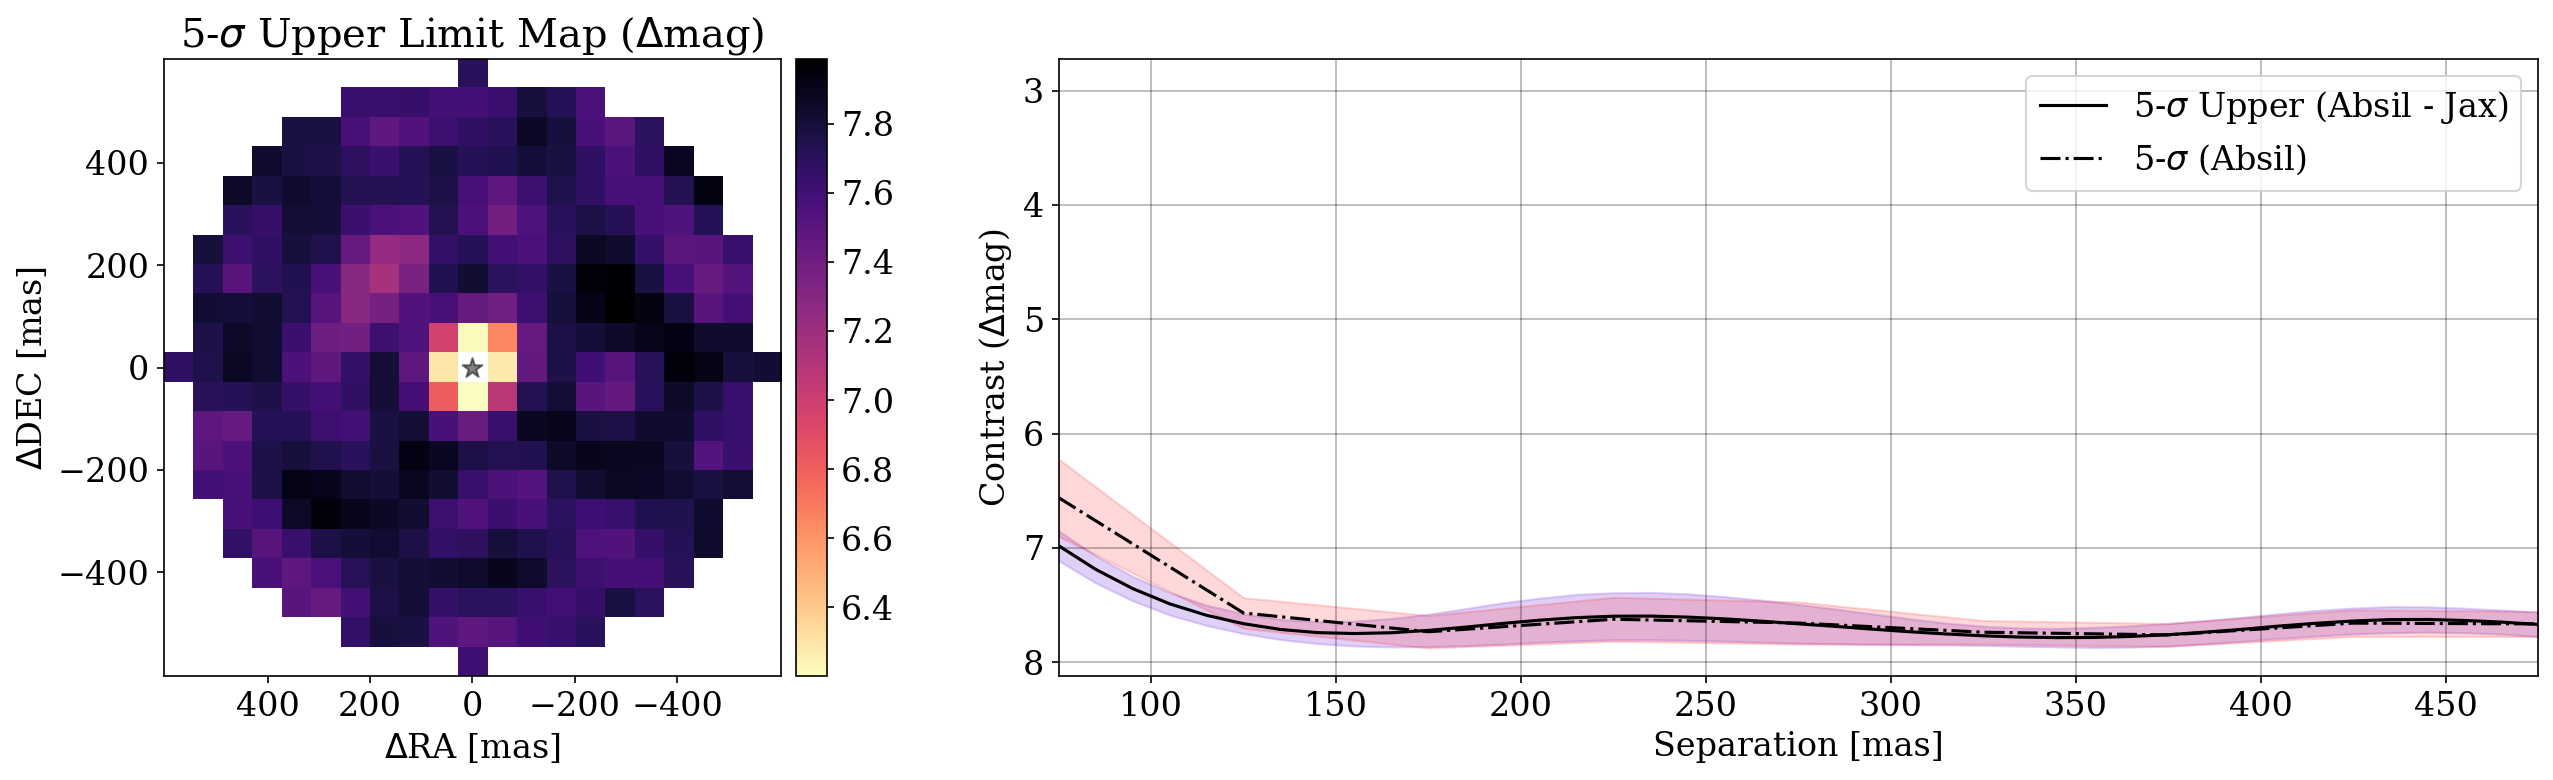

In [51]:
plt.figure(figsize=(20,5))
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['font.family'] = ['serif']
plt.rcParams.update({'font.size': 16})
plt.subplot(1,2,1)
plt.imshow(-2.5*jnp.log10(10**ffs_absil),cmap=matplotlib.colormaps['magma_r'],
                       extent=[dx*(nx)/2,-dx*(nx)/2,dx*(nx)/2,-dx*(nx)/2],
                       interpolation = 'None',alpha=1)
plt.colorbar(shrink=1, pad=0.01)
plt.scatter(0,0,marker='*',s=100,c='black',alpha=0.5)
plt.gca().invert_yaxis()
plt.title('5-$\\sigma$ Upper Limit Map ($\\Delta$mag)')
plt.xlabel('$\\Delta$RA [mas]')
plt.ylabel('$\\Delta$DEC [mas]')
plt.xticks([400,200,0,-200,-400])
plt.yticks([-400,-200,0,200,400])
plt.subplot(1,2,2)
plt.plot(rad_wdith*dx,avg_wdith,'-k',label="5-$\\sigma$ Upper (Absil - Jax)")
plt.fill_between(rad_wdith*dx,avg_wdith - std_wdith,avg_wdith + std_wdith,color=(0.6,0.4,0.9),alpha=0.3)
plt.plot(rad_t*step_size,avg_t,linestyle='dashdot',c="k",label="5-$\\sigma$ (Absil)")
plt.fill_between(rad_t*step_size,avg_t - std_t,avg_t + std_t,color="red",alpha=0.15)
plt.ylabel('Contrast ($\\Delta$mag)')
plt.xlabel('Separation [mas]')
plt.gca().invert_yaxis()
#plt.xlim(np.nanmin(rad_wdith*dx+avg_wdith*0.),np.nanmax(rad_wdith*dx+avg_wdith*0.))
plt.xlim(np.nanmin(rad_t*step_size+avg_t*0.),np.nanmax(rad_t*step_size+avg_t*0.))
plt.grid(color='black',alpha=0.3)
plt.legend(loc='best')
plt.tight_layout(pad=0.)
plt.show()